# Replicating results from [Deutsch et al., 2015, Science](https://science.sciencemag.org/content/sci/348/6239/1132.full.pdf) for Atlantic Cod

In [1]:
import numpy as np
import xarray as xr
import gsw
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf

## Load WOA dataset and select oxygen, temperature, and salinity data. Select latitude and depth range for Atlantic Cod (Fig 3.)

In [2]:
ds = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA09/woa09_monthly_1')
ds = ds.sel(lat=slice(25,70))
ds = ds.sel(lev=slice(0,400))
oxy = ds.oan
sal = ds.san
temp = ds.tan
ds = xr.merge([oxy,sal,temp])
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
ds = ds.roll(lon=180,roll_coords=True)
ds = ds.sel(lon = slice(-85,25))
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lev: 13, lon: 110, time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15 2000-02-15 ... 2000-12-15
  * lev      (lev) float64 0.0 10.0 20.0 30.0 50.0 ... 200.0 250.0 300.0 400.0
  * lat      (lat) float64 25.5 26.5 27.5 28.5 29.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 21.5 22.5 23.5 24.5
Data variables:
    oan      (time, lev, lat, lon) float32 4.9776 4.9373 4.8885 ... nan nan nan
    san      (time, lev, lat, lon) float32 36.3234 36.3155 36.2227 ... nan nan
    tan      (time, lev, lat, lon) float32 23.5145 22.8597 22.0926 ... nan nan

## We will use the Gibbs Seawater package to calculate oxygen solubility to convert O2 concentration ($\mu$mol/kg) to partial pressure.

In [3]:
gsw.O2sol_SP_pt?

Signature: gsw.O2sol_SP_pt(SP, pt)
Docstring:
Calculates the oxygen concentration expected at equilibrium with air at
an Absolute Pressure of 101325 Pa (sea pressure of 0 dbar) including
saturated water vapor.  This function uses the solubility coefficients
derived from the data of Benson and Krause (1984), as fitted by Garcia
and Gordon (1992, 1993).

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
pt : array-like
    Potential temperature referenced to a sea pressure, degrees C

Returns
-------
O2sol : array-like, umol/kg
    solubility of oxygen in micro-moles per kg
File:      ~/opt/anaconda3/envs/research3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


## First calculate pressure, absoulte salinity, potential temperature and conservative temperature

In [4]:
p = gsw.p_from_z(-ds.lev.data[:,np.newaxis],ds.lat.data[np.newaxis,:])
SA = gsw.SA_from_SP(ds.san.data,p[np.newaxis,:,:,np.newaxis],ds.lon.data,ds.lat.data[:,np.newaxis])
PT = gsw.pt0_from_t(SA,ds.tan.data,p[np.newaxis,:,:,np.newaxis])
CT = gsw.CT_from_pt(SA,PT)
rho = gsw.rho(SA,CT,p[np.newaxis,:,:,np.newaxis])
p.shape

(13, 45)

## Convert WAO O$_2$ mL/L to $\mu$mol/kg [(ref)](https://ocean.ices.dk/Tools/UnitConversion.aspx) divide by solubility and multiply by atmopspheric $P_{O2}$ to obtain partial pressure.

In [5]:
O2sol = gsw.O2sol_SP_pt(ds.san.data,PT)
O2PP = 0.21*(ds.oan.data*44.661*(rho/1000))/O2sol
O2PP.shape

(12, 13, 45, 110)

# Calculating the metabolic index using O$_2$ concentration (Fig. S2)

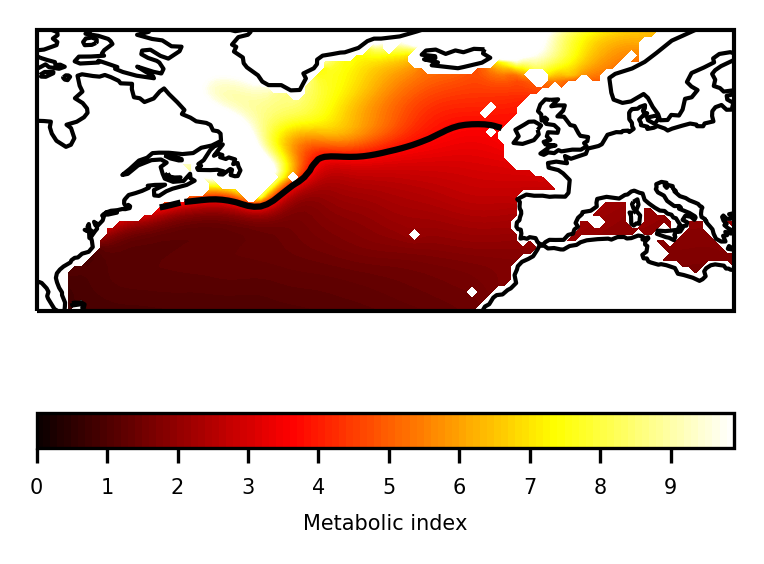

In [36]:
A0 = 9.7e-15
E0 = 0.72
kB = 8.617333262145e-5
T = ds.tan.data + 273.15
B = 1000
n = -.21
den = np.exp(-E0/(kB*T))
codMI = A0 * (B**n) * (ds.oan.data*44.661/den)
levs = np.arange(0,10,.1)
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(ds.lon.data,ds.lat.data,
            np.mean(np.mean(codMI,axis=0),axis=0),
            levels=levs,
            transform=ccrs.PlateCarree(),
            cmap=plt.cm.hot)
plt.colorbar(cl,ax=ax,
             orientation='horizontal',
             label='Metabolic index')
ax.contour(ds.lon.data,ds.lat.data,
           np.mean(np.mean(codMI,axis=0),axis=0),
           levels=[3.7],
           colors='black')

### Metabolic index based on O$_2$ partial pressure

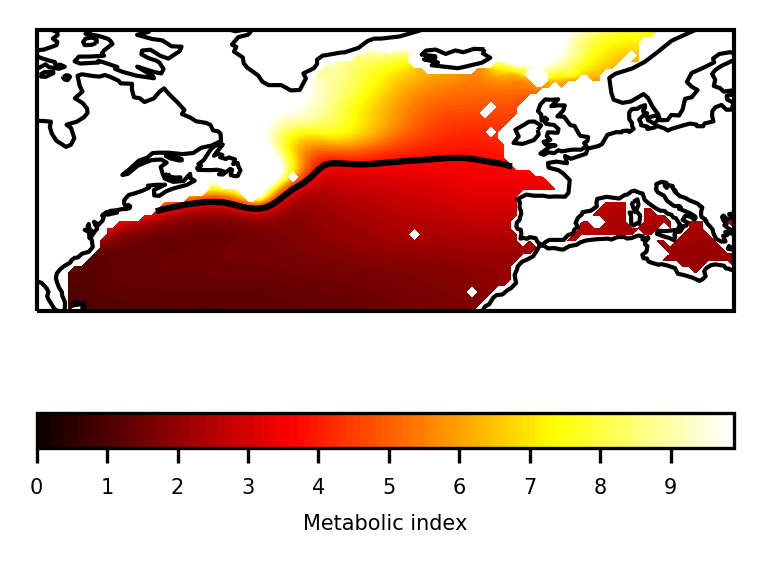

In [35]:
A0 = 3.1e-14
E0 = 0.87
kB = 8.617333262145e-5
T = ds.tan.data + 273.15
B = 1000
n = -.21
den = np.exp(-E0/(kB*T))
codMI = A0 * (B**n) * (O2PP/den)
levs = np.arange(0,10,.1)
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(ds.lon.data,ds.lat.data,
            np.mean(np.mean(codMI,axis=0),axis=0),
            levels=levs,
            transform=ccrs.PlateCarree(),
            cmap=plt.cm.hot)
plt.colorbar(cl,ax=ax,
             orientation='horizontal',
             label='Metabolic index')
ax.contour(ds.lon.data,ds.lat.data,
           np.mean(np.mean(codMI,axis=0),axis=0),
           levels=[3.7],
           colors='black')

## Calcuating the metablic index with the equation and parameters from [Penn et al, 2018](https://science.sciencemag.org/content/362/6419/eaat1327.full) (Equation is on page 3 of the supplementary info, a table of MI parameters for various species start on page 11). This calculation differs from those in Deutsch et al, 2015 (above), though the estimates are supposedly identical. Also, note that the body mass ($B^n$) term is dropped.

## Calculation from $\Phi^{crit}$:

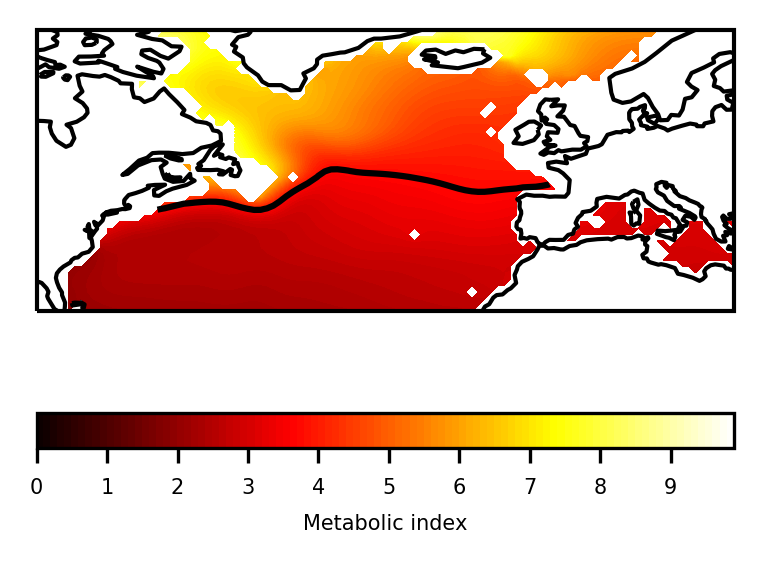

In [40]:
A0 = 15.6
E0 = 0.42
kB = 8.617333262145e-5
T = ds.tan.data + 273.15
den = np.exp(-(E0/kB)*(1/T - 1/(15+273.15)))
codMI = A0 * (O2PP/den)
levs = np.arange(0,10,.1)
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(ds.lon.data,ds.lat.data,
            np.mean(np.mean(codMI,axis=0),axis=0),
            levels=levs,
            transform=ccrs.PlateCarree(),
            cmap=plt.cm.hot)
plt.colorbar(cl,ax=ax,
             orientation='horizontal',
             label='Metabolic index')
ax.contour(ds.lon.data,ds.lat.data,
           np.mean(np.mean(codMI,axis=0),axis=0),
           levels=[3.7],
           colors='black')

## Calculation based on O$_2^{LC50}$:

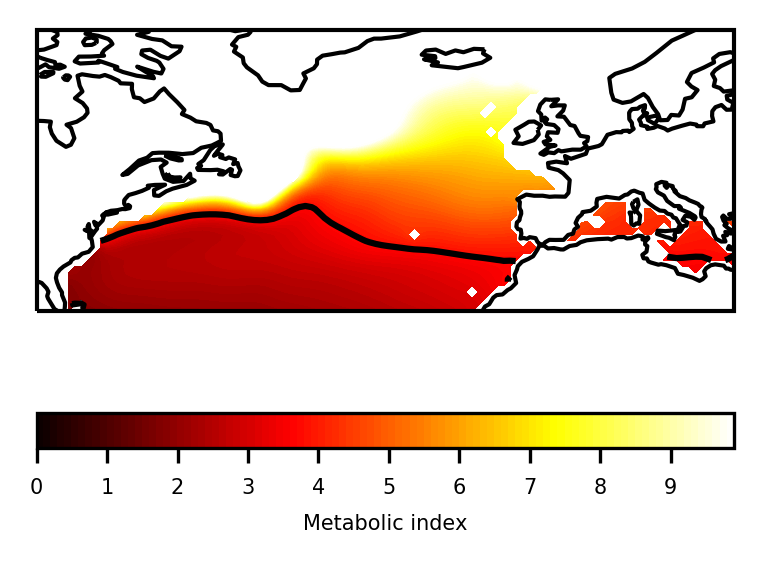

In [43]:
A0 = 21.2
E0 = 0.87
kB = 8.617333262145e-5
T = ds.tan.data + 273.15
den = np.exp(-(E0/kB)*(1/T - 1/(15+273.15)))
codMI = A0 * (O2PP/den)
levs = np.arange(0,10,.1)

plt.rcParams.update({'font.size': 5})
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(ds.lon.data,ds.lat.data,
            np.mean(np.mean(codMI,axis=0),axis=0),
            levels=levs,
            transform=ccrs.PlateCarree(),
            cmap=plt.cm.hot)
plt.colorbar(cl,ax=ax,
             orientation='horizontal',
             label='Metabolic index')
ax.contour(ds.lon.data,ds.lat.data,
           np.mean(np.mean(codMI,axis=0),axis=0),
           levels=[3.7],
           colors='black')